This notebook is used to back test the model we developed to predict stock trend predictions.

### Imports

In [1]:
import yfinance as yf
import backtrader as bt
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import json
from dateutil import tz

from fetch_stock_data import get_stock_data
from normalize_data import standardize_stock_data
from trendformer import transformer_model, feature_size, d_model, seq_length, dropout_rate, num_heads, num_layers, dff

### Pull market data for model -30 days from start day of simulation

In [ ]:
symbol = 'LSPD'
normalized_params_path = 'G:/StockData/normalized_parameters/10_EMA_3_pred.json'

start_date = (datetime.now() - timedelta(days=150)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

orig_stock_data = get_stock_data(start_date, end_date, {symbol:[]})

stock_data_df = get_stock_data(start_date, end_date, {symbol:[]}, as_json=False)
stock_data_df = stock_data_df[symbol]

with open(normalized_params_path, 'r') as file:
    normalized_params = json.load(file)

stock_data, _ = standardize_stock_data(orig_stock_data, normalized_params)

dates = stock_data[symbol]

features_to_keep = ['ATRr_14', 'week_day', 'Open', 'High', 'Low', 'Close', 'Volume','SMA_30', 'EMA_10', 'EMA_10_trend', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'RSI_10', 'BBP_5_2.0', 'avgTradingVolume', 'STOCHk_14_3_3', '52_week_high', '52_week_low', 'NASDAQ_Close', 'STOCHd_14_3_3', 'ADX_14', 'DMP_14', 'DMN_14', 'ISA_9', 'ISB_26', 'ITS_9', 'IKS_26', 'PSAR_combined']

stock_data = {date: {key: value for key, value in sorted(data.items()) if key in features_to_keep} for date, data in dates.items()}
orig_stock_data = {date: {key: value for key, value in sorted(data.items()) if key in features_to_keep} for date, data in orig_stock_data[symbol].items()}


Fetching data for DIS...
Fetching data for DIS...


### We need to pull intraday market data into a CSV for backtrader

In [ ]:
def fetch_and_save_intraday_data(symbol, interval='1d'):
    # Create the subdirectory if it doesn't exist
    if not os.path.exists('historical_intraday_market_data'):
        os.makedirs('historical_intraday_market_data')
    
    # Calculate start and end dates for the last 60 days
    end = datetime.now()
    start = end - timedelta(days=59)

    # Fetch the intraday market data
    data = yf.download(symbol, start=start, end=end, interval=interval)
    
    # Save the data to a CSV file
    filename = f'historical_intraday_market_data/{symbol}_{interval}.csv'
    data.to_csv(filename)
    
    print(f'Intraday market data for {symbol} saved to {filename}')
    return data

intra_df = fetch_and_save_intraday_data(symbol, interval='2m')
intra_df.index = pd.to_datetime(intra_df.index)

[*********************100%%**********************]  1 of 1 completed
Intraday market data for DIS saved to historical_intraday_market_data/DIS_2m.csv


### Creating model and load weights


In [4]:
# Create the transformer model
model = transformer_model(seq_length, feature_size, d_model, num_heads, dff, num_layers, dropout_rate)

# Load the weights
model.load_weights("model_weights\\10_EMA_3_pred.h5")
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 29)]          0         
                                                                 
 dense (Dense)               (None, 20, 512)           15360     
                                                                 
 tf.__operators__.add (TFOpL  (None, 20, 512)          0         
 ambda)                                                          
                                                                 
 encoder_layer_1 (Functional  (None, None, 512)        17329664  
 )                                                               
                                                                 
 encoder_layer_2 (Functional  (None, None, 512)        17329664  
 )                                                               
                                                             

### BackTest function

In [45]:
def backtest(csv_file, strategy):
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(csv_file)

    # Convert the 'Datetime' column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    # df['EMA'] = ta.ema(df['Close'], length=(30 * 6 * 21))
        # Convert 'Datetime' column to datetime format and set it as index
    df.set_index(df['Datetime'], inplace=True)

    # # Resample the data to business days only and drop NaN values
    # df = df.resample('B').mean().dropna()

    # Create a backtrader data feed
    data = bt.feeds.PandasData(dataname=df, datetime='Datetime', open='Open', high='High', low='Low', close='Close', volume='Volume')
    # Create a backtrader Cerebro instance
    cerebro = bt.Cerebro()

    keys = []
    ema_10_values = []

    for key, value in orig_stock_data.items():
        key_date = pd.to_datetime(key).date()

        if key_date in df['Datetime'].dt.date.values:
            keys.append(f"{key} 15:58:00-05:00")
            ema_10_values.append(value['EMA_10'])
    
    keys_datetime = pd.to_datetime(keys)

    # Add the data feed to the Cerebro instance
    cerebro.adddata(data)

    # Add the SMA strategy to the Cerebro instance
    cerebro.addstrategy(strategy, model)

    cerebro.addobserver(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.Value)

    # Set the initial capital
    cerebro.broker.setcash(1000)

    # Run the backtest
    results = cerebro.run(stdstats=False)

    result = results[0]

    %matplotlib ipympl
    # Extract the DateTime and Close columns from the dataframe
    x = df.index
    y = df['Close']

    # Create a new figure with extended width
    plt.figure(figsize=(12, 6))
    
    # Plot the stock prices
    plt.plot(x, y, color='black', label='Stock')

    # Add a ema 20 line
    plt.plot(keys_datetime, ema_10_values, color='blue', label='EMA 10')

    
    plt.scatter(result.trades['buy']['date'], result.trades['buy']['price'],s=100, color='green', label='Buy', zorder=3)
    plt.scatter(result.trades['sell']['date'], result.trades['sell']['price'],s=100, color='red', label='Sell', zorder=2)

    plt.scatter(result.predictions['up']['x'], result.predictions['up']['y'],s=100, marker='^', color='green', label='Buy', zorder=3)
    plt.scatter(result.predictions['down']['x'], result.predictions['down']['y'],s=100, marker='v', color='red', label='Sell', zorder=2)

    # Set the X-axis label
    plt.xlabel('Time (2 minute tick interval)')

    # Set the Y-axis label
    plt.ylabel('Stock Price')

    # Display the plot
    plt.show()

    # Plot portfolio value
    plt.figure(figsize=(12, 6))

    # Plot the stock prices
    plt.plot(result.total_value_of_portfolio['date'], result.total_value_of_portfolio['value'], color='orange', label='Portfolio Value')

    # Set the X-axis label
    plt.xlabel('Time (2 minute tick interval)')

    # Set the Y-axis label
    plt.ylabel('Portfolio Value')
    
    # Display the plot
    plt.show()

    # Print the final portfolio value
    print('Final Portfolio Value:', cerebro.broker.getvalue())

    total_commision_paid = (len(result.trades['buy']['date']) + len(result.trades['sell']['date'])) * 15
    print(f'Total Commision Paid: {total_commision_paid}')
    print(f'Net Profit: {cerebro.broker.getvalue() - total_commision_paid}')

### Trendformer Strategy


date 2023-11-22 14:30:00
2023-11-22 Prediction: 0.9852148294448853
2023-11-22 Prediction: 0.9847193956375122
2023-11-22 Prediction: 0.9856778979301453
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407
2023-11-22 Prediction: 0.9848285913467407

date 2023-11-24 14:30:00
2023-11-24 Prediction: 0.9851872324943542
2023-11-24 Prediction: 0.9851872324943542
2023-11-24 Prediction: 0.9851872324943542
2023-11-24 Prediction: 0.9851872324943542
2023-11-24 Prediction: 0.9851872324943542
2023-11-24 Prediction: 0.9851872324943542
2023-11-24 Prediction: 0.9851872324943542

date 2023-11-27 14:30:00
2023-11-27 Prediction: 0.949486911296844

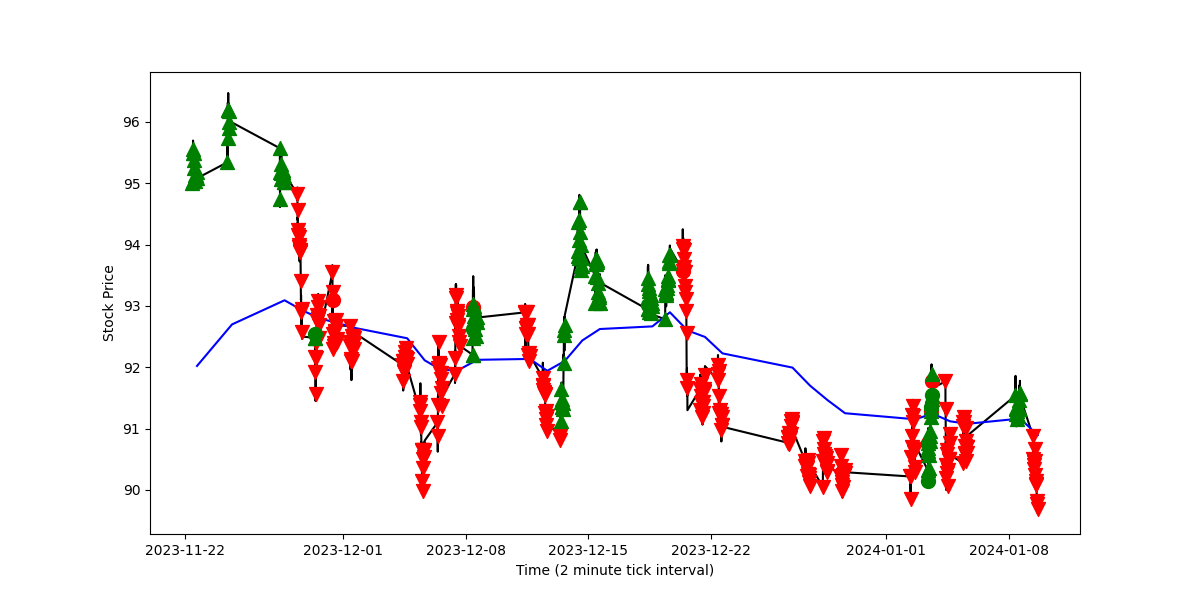

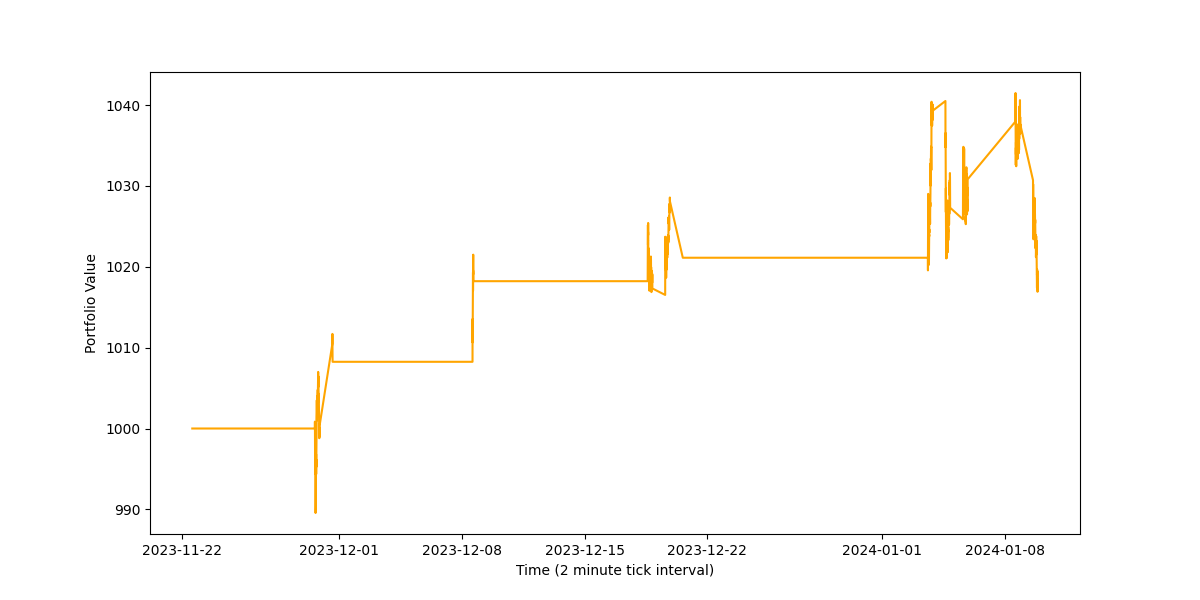

Final Portfolio Value: 1017.6243612396487
Total Commision Paid: 195
Net Profit: 822.6243612396487


In [47]:
class TrendformerStrategy(bt.Strategy):
        def __init__(self, model):
            self.model = model
            self.current_date = None
            self.past_30_days = {}
            self.buy_price = None
            self.prediction = None
            self.current_ema_10 = None
            self.size_of_order = None
            self.is_open = False
            self.average_true_range = None
            self.atr_multiple = 1.5
            self.days_since_last_prediction_check = 0
            self.triggered_stop_loss_today = False
            self.prediction_threshold = 0.6

            self.prediction_tick_counter = 0

            self.predictions = {'up': {'x': [], 'y': []}, 'down': {'x': [], 'y': []}}

            # List of trades. Type: {date, price}
            self.trades = {'buy': {'date': [], 'price': []}, 'sell': {'date': [], 'price': []}}
            self.total_value_of_portfolio = {'date': [], 'value': []}
            # Keep track of days
            self.day = 0

        def next(self):
            # Get the current iteration date
            current_date = self.data.datetime.datetime()
            
            # Convert current date to string in format YYYY-MM-DD
            current_date_str = current_date.strftime('%Y-%m-%d')
   
            # Wait 30 minutes before making a prediction.
            if self.current_date != current_date_str and current_date_str in stock_data:
                self.traded_today = False

                if self.getposition(self.data).size > 0 and self.days_since_last_prediction_check < 3:
                    self.days_since_last_prediction_check += 1
                    print(f"Days since last prediction check: {self.days_since_last_prediction_check}")
                print(f"\ndate {current_date}")
                self.prediction = self.predict_future_emas()
                
                
                if self.getposition(self.data).size > 0 and self.days_since_last_prediction_check == 3:
                    print(f"3 days have passed since last prediction check. {self.data.close[0]}")
                    self.days_since_last_prediction_check = 0
                    # Only sell if we predict a downtrend. Otherrwise we hold.
                    if self.is_open == False and self.prediction < self.prediction_threshold:
                        self.is_open = True
                        self.close()
                        print(f"3 days have passed since last prediction check and new prediction is down. Close position. {self.data.close[0]}")

               
            self.prediction_tick_counter += 1
            if self.prediction_tick_counter == 15:
                self.prediction_tick_counter = 0
                self.predict_future_emas()
            
            # I also need to run this against a list of stocks and not just 1. 
            if self.triggered_stop_loss_today == False and self.is_open == False and self.getposition(self.data).size == 0 and self.prediction > self.prediction_threshold and self.data.close[0] < self.current_ema_10*(1+((self.average_true_range*0.2)/100)):
                #Before we buy we make another prediction to make sure there still is an uptrend.
                print(f"Checking if there still is an uptrend. {self.prediction}")
                self.prediction = self.predict_future_emas()
                print(f"Prediction after checking if there still is an uptrend. {self.prediction}")
                # If It is we buy
                if self.prediction > self.prediction_threshold:
                    # Get the current cash
                    cash1 = self.broker.getcash() * 0.99

                    # Calculate the number of shares to buy
                    self.size_of_order = cash1 // self.data.close[0]
                    self.is_open = True
                    self.buy(size=self.size_of_order,price=self.data.close[0])


            # Create a stop loss order if the price drops below 5% of the buy price
            if self.is_open == False and self.getposition(self.data).size > 0 and self.data.close[0] < self.buy_price * ((100 - self.average_true_range*2) / 100):
                self.is_open = True
                self.close()
                self.triggered_stop_loss_today = True
                print(f"Stop loss triggered. {self.data.close[0]}")

            # Create a trailing stop loss order with a 2% trailing stop if the price is above the buy price
            # Need to offset this by commision price otherwise we end up losing money.
            if self.is_open == False and self.getposition(self.data).size > 0 and self.data.close[0] > self.buy_price * ((100 + (self.average_true_range*0.5)) / 100):
                self.is_open = True
                self.sell(size=self.size_of_order, exectype=bt.Order.StopTrail, trailpercent=(((self.average_true_range*0.2) / 100)))
                print(f"Trailing stop loss triggered price is above average true range and went down a bit. {self.data.close[0]}")


            self.total_value_of_portfolio['date'].append(self.data.datetime.datetime())
            self.total_value_of_portfolio['value'].append(self.broker.getvalue())
            self.day+=1


        # Manually adding the intra day data to the 20 day sequence. It's gross but works. 
        def predict_future_emas(self):
            # Get the current iteration date
            current_date = self.data.datetime.datetime()
            # Convert current date to string in format YYYY-MM-DD
            current_date_str = current_date.strftime('%Y-%m-%d')

            self.current_date = current_date_str

            # Convert the index to datetime objects
            stock_data_df.index = pd.to_datetime(stock_data_df.index)
            # Find the index of the specified date
            date_index = stock_data_df.index.get_loc(current_date_str)

            # Get the last 19 rows of data
            previous_19_days = stock_data_df.iloc[max(0, date_index - 60):date_index]
            # Assuming intra_df is your DataFrame and it has datetime as index
            # Convert current_date to a timezone-aware datetime object
            current_date = current_date.replace(tzinfo=tz.gettz('America/New_York'))
            # Now you can use asof
            nearest_date = intra_df.index.asof(current_date)
            row = intra_df.loc[nearest_date]

            # Make sure 'row' is a DataFrame, not a Series
            row = pd.DataFrame(row).transpose()
            
            row.index = row.index.strftime('%Y-%m-%d')
            previous_19_days.index = previous_19_days.index.strftime('%Y-%m-%d')
            # Concatenate previous_19_days with row
            previous_20_days = pd.concat([previous_19_days, row])

            previous_20_days.index = pd.to_datetime(previous_20_days.index)

            columns_to_drop = [column for column in previous_20_days.columns if column not in row.columns and column not in ['52_week_high', '52_week_low', 'NASDAQ_Close']]
            columns_to_drop.append('Adj Close')
            previous_20_days.drop(columns=columns_to_drop, inplace=True)

            previous_20_days['week_day'] = previous_20_days.index.dayofweek + 1
    
            # Calculating technical indicators using pandas_ta
            previous_20_days.ta.sma(length=10, column='Volume', append=True)
            previous_20_days.rename(columns={'SMA_10': 'avgTradingVolume'}, inplace=True)
            previous_20_days.ta.sma(length=30, append=True)
            # previous_20_days.ta.sma(length=33, append=True)
            previous_20_days.ta.ema(length=10, append=True)  # Short-term EMA
            previous_20_days.ta.macd(append=True)  # MACD
            previous_20_days.ta.rsi(length=10, append=True)  # RSI
            previous_20_days.ta.bbands(append=True)  # Bollinger Bands
            previous_20_days.ta.adx(length=14, append=True)
            previous_20_days.ta.ichimoku(append=True)
            previous_20_days.ta.atr(length=14, append=True)

            # Calculate the difference between the current and previous day's EMA_20 values
            previous_20_days['EMA_10_diff'] = previous_20_days['EMA_10'].diff()

            # Create a new column 'EMA_20_trend' that is 0 if the EMA_20 went down and 1 if it went up
            previous_20_days['EMA_10_trend'] = previous_20_days['EMA_10_diff'].apply(lambda x: 1 if x > 0 else 0)

            # Drop the 'EMA_20_diff' column as it's no longer needed
            previous_20_days.drop(columns=['EMA_10_diff'], inplace=True)

            # Adding Stochastic Oscillator
            previous_20_days.ta.stoch(high='High', low='Low', close='Close', k=14, d=3, append=True)

            # Adding Parabolic SAR
            previous_20_days.ta.psar(high='High', low='Low', close='Close', append=True)

            # Combine the two PSAR columns into one, filling NaN values from one column with values from the other
            previous_20_days['PSAR_combined'] = previous_20_days['PSARl_0.02_0.2'].fillna(previous_20_days['PSARs_0.02_0.2'])

            
            # Drop the individual PSARl and PSARs columns
            previous_20_days.drop(columns=['PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'ICS_26'], inplace=True)

            # Calculate 52-week high and low
            previous_20_days['52_week_high'] = previous_20_days['Close'].max()
            previous_20_days['52_week_low'] = previous_20_days['Close'].min()
            previous_20_days['NASDAQ_Close'] = previous_20_days['NASDAQ_Close'].ffill()
            previous_20_days = previous_20_days.fillna(0)
            
            previous_20_days = previous_20_days.tail(20)


            previous_20_days = previous_20_days.to_dict(orient='index')
            previous_20_days ={symbol: {key.strftime('%Y-%m-%d'): value for key, value in previous_20_days.items()}}
            

            self.current_ema_10 = previous_20_days[symbol][current_date_str]['EMA_10']
            self.average_true_range = previous_20_days[symbol][current_date_str]['ATRr_14']
            
            
            norm_previous_20_days, _ = standardize_stock_data(previous_20_days, normalized_params)
            norm_previous_20_days = {date: {key: value for key, value in sorted(data.items()) if key in features_to_keep} for date, data in norm_previous_20_days[symbol].items()}
            
            norm_previous_20_days = np.array([list(day.values()) for day in norm_previous_20_days.values()])
            norm_previous_20_days = np.expand_dims(norm_previous_20_days, axis=0)
            

            prediction = self.model.predict(norm_previous_20_days, verbose=0)
            prediction = prediction[0][0]

            if prediction > self.prediction_threshold:
                self.add_prediction('up', self.data.datetime.datetime(), self.data.close[0])
            else:
                self.add_prediction('down', self.data.datetime.datetime(), self.data.close[0])
            
            print(f"{current_date_str} Prediction: {prediction}")

            
            return prediction


        def add_trade(self, type='buy', date=0, price=1):
            self.trades[type]['date'].append(date)
            self.trades[type]['price'].append(price)
        
        def add_prediction(self, type='up', x=0, y=0):
            self.predictions[type]['x'].append(x)
            self.predictions[type]['y'].append(y)
        
        def notify_order(self, order):
            if order.status in [order.Completed]:
                if order.isbuy():
                    # Add the trade to later plot
                    self.add_trade('buy', self.data.datetime.datetime(), self.data.close[0])
                    self.is_open = False
                    self.days_since_last_prediction_check = 0
                    # Get the current price
                    self.buy_price = order.executed.price
                    self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                            (order.executed.price,
                            order.executed.value,
                            order.executed.comm))
                else:  # Sell
                    self.add_trade('sell', self.data.datetime.datetime(), self.data.close[0])
                    self.is_open = False
                    self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                            (order.executed.price,
                            order.executed.value,
                            order.executed.comm))
            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')
                self.log('Order Info: Price: %.2f, Size: %.2f' % (order.created.price, order.created.size))
        
        def log(self, txt, dt=None):
            ''' Logging function for this strategy'''
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))
                    
backtest(f'historical_intraday_market_data/{symbol}_2m.csv', TrendformerStrategy)

### SMA Strategy

2023-11-24, BUY EXECUTED, Price: 95.90, Cost: 959.00, Comm 0.00


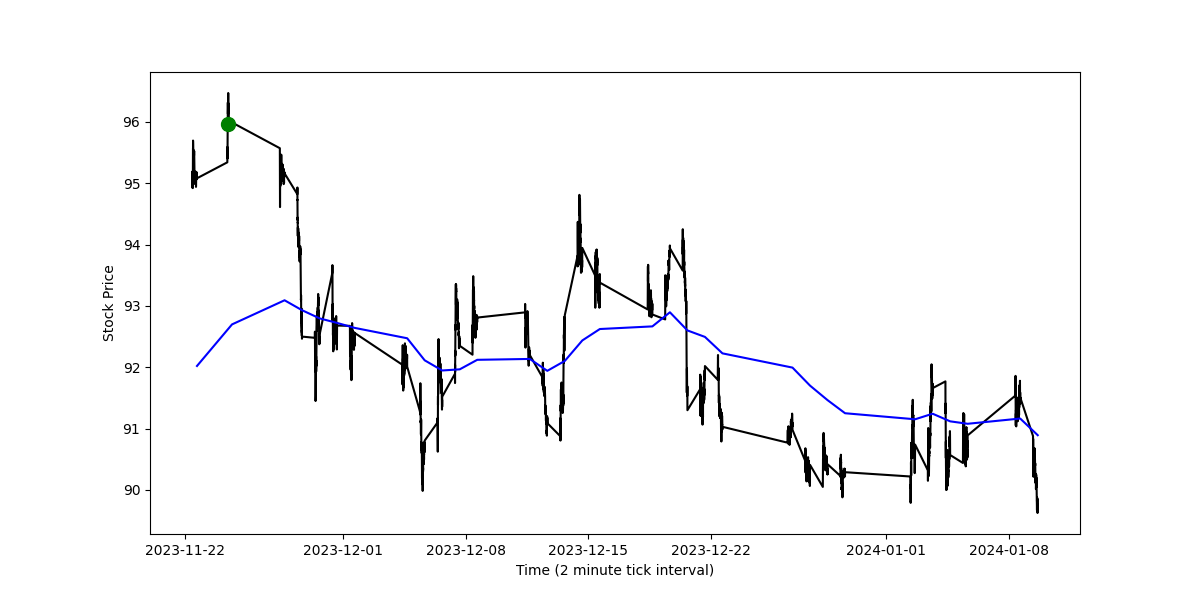

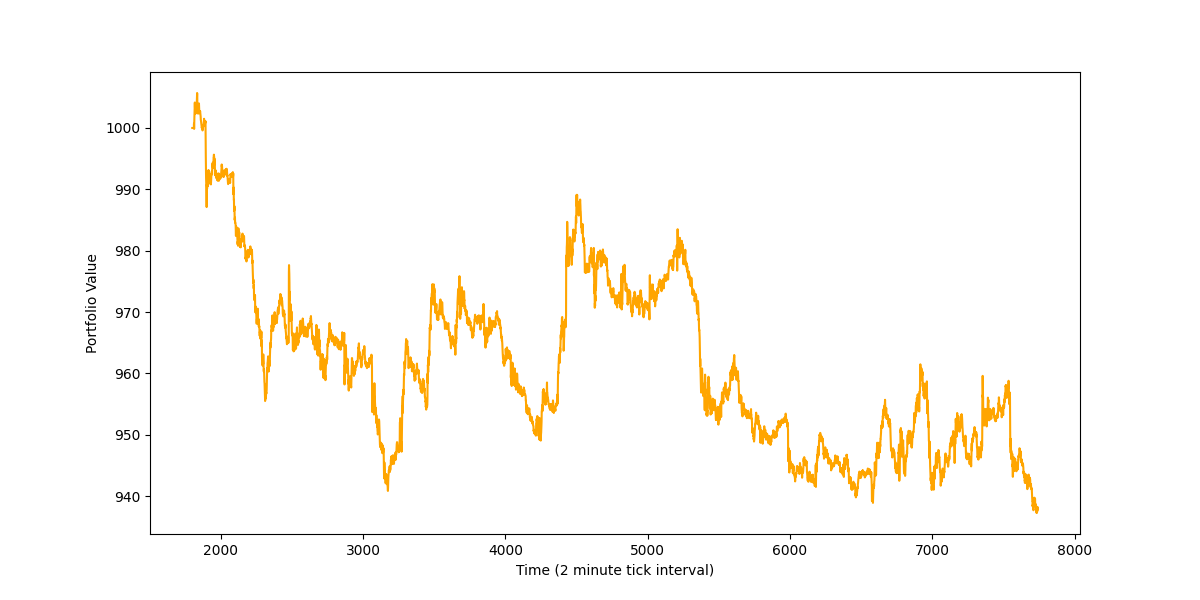

Final Portfolio Value: 937.9000091552734
Total Commision Paid: 15
Net Profit: 922.9000091552734


In [43]:
class SMAStrategy(bt.Strategy):
    # OHHhhhh. The library waits the SMA period before it starts running the strategy. So this number has to match the self.days value
    # to plot it correctly.
    params = (
    ('short_period', 50),  # Period for the short-term moving average
    ('long_period', 200),  # Period for the long-term moving average
    )

    def __init__(self, model):
        self.short_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.short_period
        )
        self.long_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.long_period
        )
        self.size = None
        self.is_open = False
        # List of trades. Type: {date, price}
        self.trades = {'buy': {'date': [], 'price': []}, 'sell': {'date': [], 'price': []}}
        self.total_value_of_portfolio = {'date': [], 'value': []}
        # Keep track of days.. Actually 2 minute ticks lol. Dont ask... 
        self.day = (30 * 6 * 10) - 1

    def next(self):
        if self.short_ma[0] > self.long_ma[0] and self.short_ma[-1] < self.long_ma[-1] and self.is_open == False:
            # Get the current price
            self.buy_price = self.data.close[0]

            # Get the current cash
            cash = self.broker.getcash()

            # Calculate the number of shares to buy
            self.size = cash // self.buy_price

            self.buy(size=self.size)
            

            

        if self.short_ma[0] < self.long_ma[0] and self.short_ma[-1] > self.long_ma[-1] and self.is_open == False:
            # self.sell(size=self.size)
            self.close()

        
            
        self.total_value_of_portfolio['date'].append(self.day)
        self.total_value_of_portfolio['value'].append(self.broker.getvalue())
        self.day+=1

    def add_trade(self, type='buy', date=0, price=1):
        self.trades[type]['date'].append(date)
        self.trades[type]['price'].append(price)

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                # Add the trade to later plot
                self.add_trade('buy', self.data.datetime.datetime(), self.data.close[0])
                self.is_open = True
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                        order.executed.value,
                        order.executed.comm))
            else:  # Sell
                self.add_trade('sell', self.data.datetime.datetime(), self.data.close[0])
                self.is_open = True
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                        order.executed.value,
                        order.executed.comm))
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            self.log('Order Info: Price: %.2f, Size: %.2f' % (order.created.price, order.created.size))
        
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))


backtest(f'historical_intraday_market_data/{symbol}_2m.csv', SMAStrategy)

### Buy and Hold Strategy

keys: ['2023-11-22 15:58:00-05:00', '2023-11-24 15:58:00-05:00', '2023-11-27 15:58:00-05:00', '2023-11-28 15:58:00-05:00', '2023-11-29 15:58:00-05:00', '2023-11-30 15:58:00-05:00', '2023-12-01 15:58:00-05:00', '2023-12-04 15:58:00-05:00', '2023-12-05 15:58:00-05:00', '2023-12-06 15:58:00-05:00', '2023-12-07 15:58:00-05:00', '2023-12-08 15:58:00-05:00', '2023-12-11 15:58:00-05:00', '2023-12-12 15:58:00-05:00', '2023-12-13 15:58:00-05:00', '2023-12-14 15:58:00-05:00', '2023-12-15 15:58:00-05:00', '2023-12-18 15:58:00-05:00', '2023-12-19 15:58:00-05:00', '2023-12-20 15:58:00-05:00', '2023-12-21 15:58:00-05:00', '2023-12-22 15:58:00-05:00', '2023-12-26 15:58:00-05:00', '2023-12-27 15:58:00-05:00', '2023-12-28 15:58:00-05:00', '2023-12-29 15:58:00-05:00', '2024-01-02 15:58:00-05:00', '2024-01-03 15:58:00-05:00', '2024-01-04 15:58:00-05:00', '2024-01-05 15:58:00-05:00']


 ema_10_values: [232.01005392919112, 232.63549811447314, 233.26177151748797, 235.708722372618, 237.24168183025992, 237.75

AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_Strateg' object has no attribute 'trades'

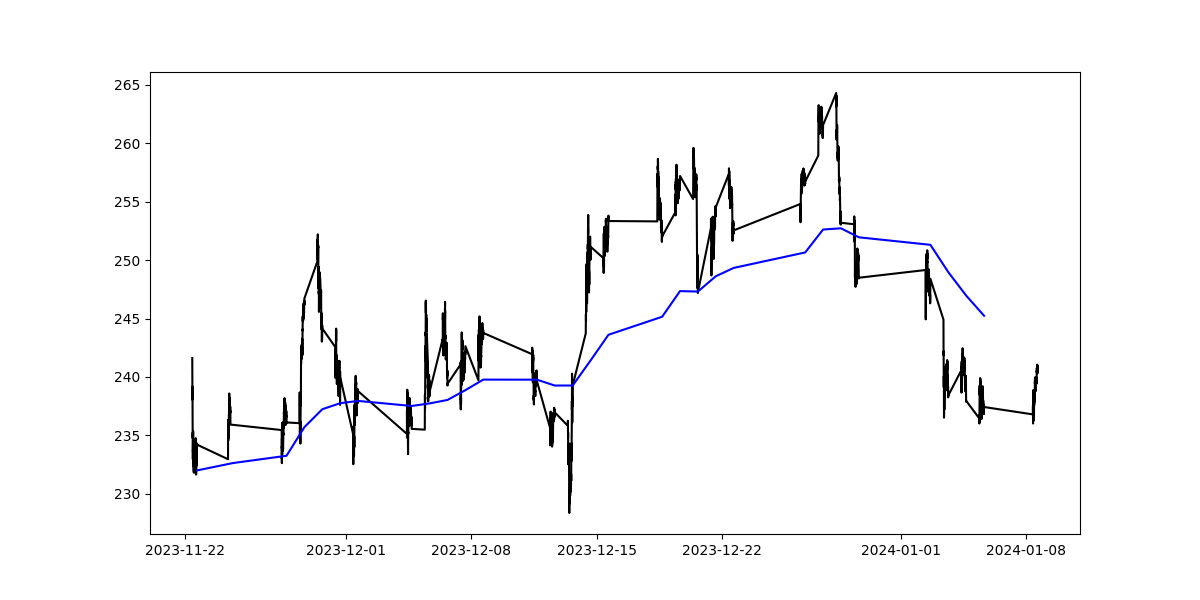

In [47]:
class BuyAndHoldStrategy(bt.Strategy):
    def __init__(self, model):
        pass

    def next(self):
        if not self.position:
            self.buy()

backtest(f'historical_intraday_market_data/{symbol}_2m.csv', BuyAndHoldStrategy)

### Moving Average Crossover Strategy

C:\Users\Aman\AppData\Local\Temp\ipykernel_2764\84711492.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Datetime'] = pd.to_datetime(df['Datetime'])


Sell at 223.37879943847656 to lock in profit
Current portfolio value: 102356.50872802731
Sell at 250.48019409179688 to lock in profit
Current portfolio value: 102819.03742980948


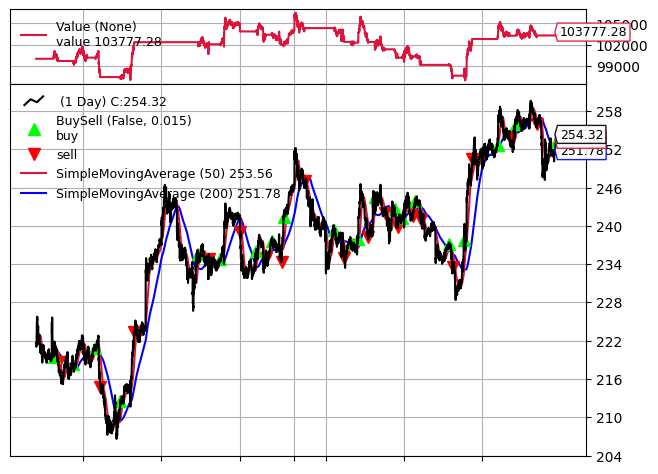

Final Portfolio Value: 103777.28096008289


In [11]:
class MovingAverageCrossoverStrategy(bt.Strategy):
    params = (
        ('short_period', 50),  # Period for the short-term moving average
        ('long_period', 200),  # Period for the long-term moving average
    )

    def __init__(self, model):
        self.short_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.short_period
        )
        self.long_ma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.long_period
        )
        self.size = None
        self.is_open = False
        self.buy_price = None

    def next(self):
        if self.short_ma[0] > self.long_ma[0] and self.short_ma[-1] < self.long_ma[-1] and self.is_open == False:
            # Get the current price
            self.buy_price = self.data.close[0]

            # Get the current cash
            cash = self.broker.getcash()

            # Calculate the number of shares to buy
            self.size = cash // self.buy_price

            self.buy(size=self.size)
            self.is_open = True
        if self.short_ma[0] < self.long_ma[0] and self.short_ma[-1] > self.long_ma[-1] and self.is_open == True:
            self.sell(size=self.size)
            self.is_open = False
        # Tick by tick sell logic
        if self.is_open == True:
            
            # Stop loss
            if self.data.close[0] < self.buy_price * 0.95:
                self.sell(size=self.size)
                self.is_open = False
                print(f"Sell at {self.data.close[0]} to stop loss")
                print(f"Current portfolio value: {self.broker.getvalue()}")

            # Sell if price is 5% above buy price
            elif self.data.close[0] > self.buy_price * 1.05:
                self.sell(size=self.size)
                self.is_open = False
                print(f"Sell at {self.data.close[0]} to lock in profit")
                print(f"Current portfolio value: {self.broker.getvalue()}")

backtest(f'historical_intraday_market_data/{symbol}_2m.csv', MovingAverageCrossoverStrategy)

### Relative Strength Index (RSI) Strategy

C:\Users\Aman\AppData\Local\Temp\ipykernel_2764\84711492.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Datetime'] = pd.to_datetime(df['Datetime'])


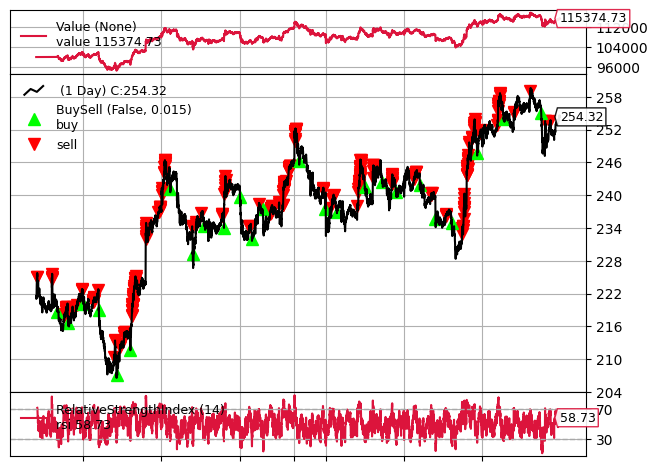

Final Portfolio Value: 115374.73017883301


In [12]:
class RSIStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),  # Period for the RSI
        ('rsi_buy_threshold', 30),  # RSI threshold for buying
        ('rsi_sell_threshold', 70),  # RSI threshold for selling
    )

    def __init__(self, model):
        self.rsi = bt.indicators.RelativeStrengthIndex(
            self.data.close, period=self.params.rsi_period
        )

    def next(self):
        if self.rsi[0] < self.params.rsi_buy_threshold:
            # Get the current price
            buy_price = self.data.close[0]

            # Get the current cash
            cash = self.broker.getcash()

            # Calculate the number of shares to buy
            self.size = cash // buy_price

            self.buy(size=self.size)
        elif self.rsi[0] > self.params.rsi_sell_threshold:
            self.sell()

backtest(f'historical_intraday_market_data/{symbol}_2m.csv', RSIStrategy)


### MACD Strategy

C:\Users\Aman\AppData\Local\Temp\ipykernel_2764\84711492.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Datetime'] = pd.to_datetime(df['Datetime'])


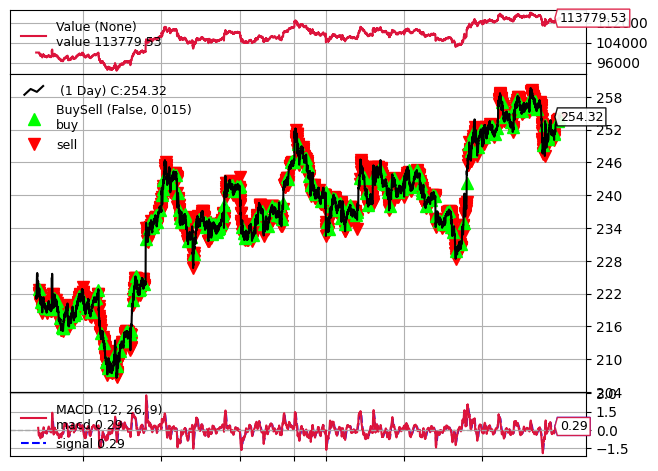

Final Portfolio Value: 113779.53253173828


In [13]:
class MACDStrategy(bt.Strategy):
    def __init__(self, model):
        self.macd = bt.indicators.MACD(self.data.close)

    def next(self):
        if self.macd.macd[0] > self.macd.signal[0]:
            # Get the current price
            buy_price = self.data.close[0]

            # Get the current cash
            cash = self.broker.getcash()

            # Calculate the number of shares to buy
            self.size = cash // buy_price

            self.buy(size=self.size)
        elif self.macd.macd[0] < self.macd.signal[0]:
            self.sell()

backtest(f'historical_intraday_market_data/{symbol}_2m.csv', MACDStrategy)

### Bollinger Bands Strategy

C:\Users\Aman\AppData\Local\Temp\ipykernel_2764\84711492.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Datetime'] = pd.to_datetime(df['Datetime'])


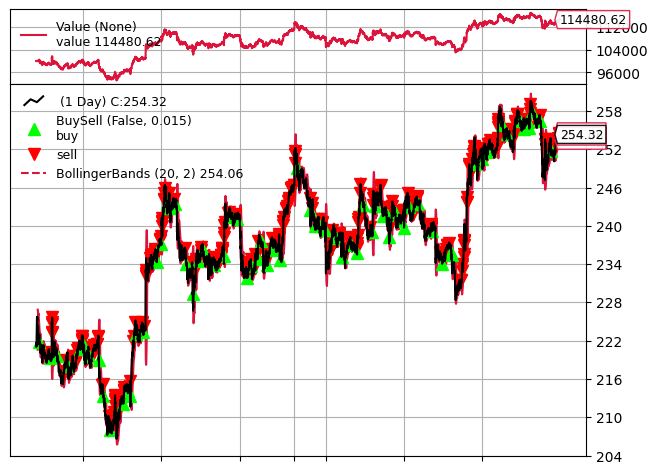

Final Portfolio Value: 114480.62158203125


In [14]:
class BollingerBandsStrategy(bt.Strategy):
    params = (
        ('bb_period', 20),  # Period for the Bollinger Bands
        ('bb_devfactor', 2),  # Standard deviation factor for the Bollinger Bands
    )

    def __init__(self, model):
        self.bbands = bt.indicators.BollingerBands(
            self.data.close, period=self.params.bb_period, devfactor=self.params.bb_devfactor
        )

    def next(self):
        if self.data.close[0] < self.bbands.lines.bot[0]:
           # Get the current price
            buy_price = self.data.close[0]

            # Get the current cash
            cash = self.broker.getcash()

            # Calculate the number of shares to buy
            self.size = cash // buy_price

            self.buy(size=self.size)
        elif self.data.close[0] > self.bbands.lines.top[0]:
            self.sell()

backtest(f'historical_intraday_market_data/{symbol}_2m.csv', BollingerBandsStrategy)


### Custom Strategy using multiple technical indicators

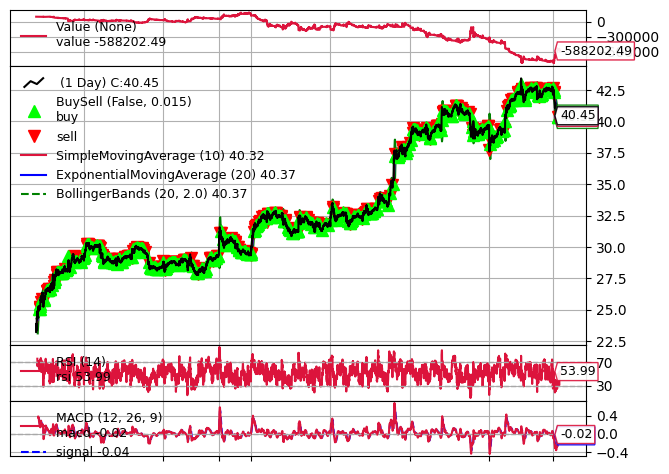

Final Portfolio Value: -588202.4854907822


In [24]:
class CustomStrategy(bt.Strategy):
    def __init__(self, model):
        self.model = model
        self.indicators = []

        # Add your technical indicators here
        self.indicators.append(bt.indicators.SimpleMovingAverage(self.data.close, period=10))
        self.indicators.append(bt.indicators.ExponentialMovingAverage(self.data.close, period=20))
        self.indicators.append(bt.indicators.RSI(self.data.close, period=14))
        self.indicators.append(bt.indicators.MACD(self.data.close))
        self.indicators.append(bt.indicators.BollingerBands(self.data.close))
        self.size = None

    def next(self):
        buy_signals = 0
        sell_signals = 0

        # Check the signals of each indicator
        for indicator in self.indicators:
            if indicator[0] > indicator[-1]:
                buy_signals += 1
            elif indicator[0] < indicator[-1]:
                sell_signals += 1

        # Buy if 3 of the 5 indicators signal buy
        if buy_signals >= 3 and self.size == None:
            # Get the current price
            buy_price = self.data.close[0]

            # Get the current cash
            cash = self.broker.getcash()

            # Calculate the number of shares to buy
            self.size = cash // buy_price

            self.buy(size=self.size)

        # Sell if 3 of the 5 indicators signal sell
        elif sell_signals >= 3 and self.size != None:
            self.sell(size=self.size)
            self.size = None

backtest(f'historical_intraday_market_data/{symbol}_2m.csv', CustomStrategy)